[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Particle Filters

In [2]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import matplotlib.pyplot as plt
import book_format
book_format.load_style()

Here is our problem. We have object moving in a space, and we want to track them. Maybe the objects are fighter jets and missiles in the sky, or maybe we are tracking people playing cricket in a field. It doesn't really matter. Which of the filters that we have learned can handle this problem? Well, none of them are ideal. Let's think about the characteristics of this problem. 

1. **multi-modal**: We want to track zero, one, or more than one object simultaneously.

2. **occlusions**: One object can hide another, causing there to be only one measurement for multiple objects.

3. **nonlinear behavior**: Aircraft are buffeted by winds, balls move in parabolas, and people collide into each other.

4. **nonlinear measurements**: Radar gives us the distance to an object. Converting that to an (x,y,z) coordinate requires a square root, which is nonlinear.

5. **non-Gaussian noise:** as objects move across a background the computer vision can mistake part of the background for the object. 

6. **continuous:** the object's position and velocity (i.e. the state space) can smoothly vary over time.

7. **multivariate**: we want to track several attributes, such as position, velocity, turn rates, etc.

None of the filters we have learned work well with all of these constraints. 

* **Discrete Bayes filter**: This has most of the attributes. It is multimodal, can handle nonlinear measurements, and can be made to work with nonlinear behavior (in this book we only handled the linear case). However, it is discrete, not continuous, and it is *univariate*, not multivariate.

* **Kalman filter**: The Kalman filter produces optimal estimates for unimodal linear systems with Gaussian noise. None of these are true for our problem.

* **Unscented Kalman filter**: The UKF handles nonlinear, continuous, multivariate problems. However, it is neither multimodal nor does it handle occlusions. It can handle noise that is modestly non-Gaussian, but does not do well with distributions that are very non-Gaussian.

* **Extended Kalman filter**: The EKF has the same strengths and limitations as the UKF, except that is it even more sensitive to strong nonlinearities and non-Gaussian noise.

## some title

The particle filter is easy to understand, and I could explain the entire algorithm to you now. But I want you to understand it within the context of the other Bayesian filters in this book. When you design a filter you first have to choose which filter to use, and understanding the relative strengths and weaknesses of each is important.

So let's start with a chart we first saw in the *Nonlinear Filtering* chapter. We started with a Gaussian with a mean of 0 and a variance of 1 and created 500,000 random points fitting that distribution. We passed each of those points through a nonlinear function, and plotted the result.

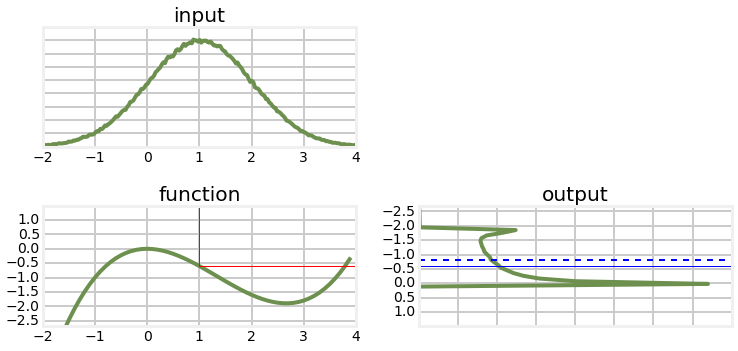

In [5]:
import numpy as np
from numpy.random import normal
from nonlinear_plots import plot_transfer_func

gaussian = (1., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def g(x):
    return .2*x**3 - .8*x**2

with book_format.figsize(y=5):
    plot_transfer_func(data, g, gaussian)

The EKF deals with this problem by linearizing the function at $x$ by evaluating the derivative at x: $f'(x)$. This computes the slope of the function at $x$, which is a linear function. If the function is smooth and 'fairly' linear locally the EKF produces a reasonable but suboptimal result. We can see from the chart above how much error is incurred with this linearization. 

The UKF handles larger nonlinearities by taking $2n+1$ samples near $x$. These samples are passed through the function, and the mean and standard deviation of the transformed points are used as the new estimate for the system state. In general this provides better estimates than the EKF at the cost of more computation. 

The EKF represents the nonlinearity of the function with one point, and the UKF represents it with $2n+1$ points. This allows them to handle the nonlinearity of the function, but in the end both assume a Gaussian distribution by taking the mean and standard deviation of the sampled points. 

It has probably occurred to you that the code that I used to graph the solution above constitutes an accurate solution, and it is. In other words, if we take a *large enough* sample from any probability distribution and pass them through our function the result will be an accurate representation of the new mean and probability distribution. 

The drawback to this approach is the amount of computation required. The charts above create half a million points to achieve their accuracy, and this is only a 1D problem. A typical tracking problem might have 9 or more dimensions (in 3D: position, velocity, attitude). Even with today's computers the problem quickly becomes computational intractable for real time tracking.

## some title

All of this brings us to the particle filter. Going back to the problem that opened the chapter, let's discuss tracking objects using computer vision. For the time being we will stay in 2 spatial dimensions just because it is easier to plot for the book. Assume we have computer vision software that identifies moving objects in a video and creates 'blobs' where each blob is a potential object. Each blob can have error - shadows or the background may make the blob larger or smaller than the actual object, and spurious data such as insects flying near the lens can cause outlier data. Assume we know the camera pose and a terrain map and thus have a function that converts the screen coordinates of a blob to a 2D world position. We want to track the position and velocity of all objects in the video.

Taking insight from the discussion above we start by creating a few thousand *particles*. Each particle represents a possible belief of where an object is in the video. We want to track position and motion, so each particle will be assigned a random position and velocity. Here is a function that creates a particle in a square with a random velocity. We ignore units, trusting that the caller will use self consistant units such as MKS. Each particle is represented as a list with the structure `[x_position, y_position, speed, direction]`

In [3]:
from random import uniform
from math import pi
def make_particle(xrange=(0, 100), yrange=(0, 100), max_velocity=2.):
    return [uniform(*xrange), uniform(*yrange), 
            uniform(0, max_velocity), uniform(0, 2*pi)]



Here we create 1000 random plots and plot them.

In [7]:
particles = np.asarray([make_particle((0, 100), (0, 100), 2) for i in range(1000)])

Now we can write code that moves the particle over a period of time.

In [8]:
def move(particles, t=1.):
    vx = particles[:, 2]*np.cos(particles[:, 3])
    vy = particles[:, 2]*np.sin(particles[:, 3])
    particles[:, 0] = (particles[:, 0] + vx*t) % 100
    particles[:, 1] = (particles[:, 1] + vy*t) % 100

So let's plot the particles, move them, and plot them again

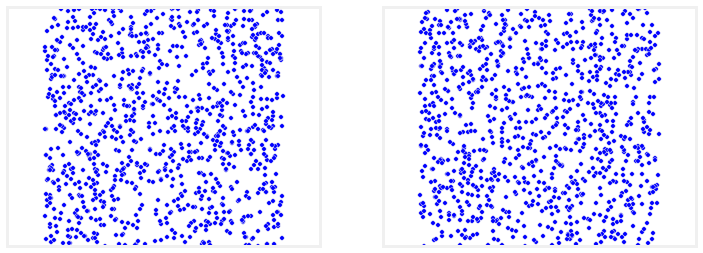

In [11]:
def plot_particles(particles, x_range=(0, 100), y_range=(0, 100)):
    with book_format.figsize(4,4):
        plt.scatter(particles[:, 0], particles[:, 1])
        plt.axis('equal')
        plt.xlim(*x_range)
        plt.ylim(*y_range)
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])

plt.subplot(121)
plot_particles(particles)
move(particles, t=10)
plt.subplot(122)
plot_particles(particles)

It is difficult to visualize the movement from two static images, so here is an animation.
<img src='animations/13_particle_move.gif'>

So we have a random distribution of particles, how do we use them to track objects? Think of these particles as *beliefs*. We want each particle to represent a possible belief for the movement of a tracked object. Each particle only contains a position and velocity, so we need a separate data structure to contain the probability that the particle is tracking an object. Much like we did in the **Discrete Bayes** chapter we can use a NumPy array to store the probabilities. 

We have not yet incorported any measurements, so if you recall from the Bayesian math sections we would call this our *prior*, as it contains the probability *prior* to adding a measurement. With no measurements we have no reason to believe any particular particle is more likely to be correct than any other particle, so it is reasonable to assign the same probability to each. We want a *probability distribution*, which means that the sum of the probabilities of all the particles must be one. Here is some code to do that.

In [19]:
N=len(particles)
p = np.array([1/N]*N)

We have 1,000 particles so the probability for each particle is 0.001 (1/1000). 

Now how do we incorporate measurements? Say we run our computer vision software on the first video frame and it reports that there is a blob at (43.2, 21.8). We can evaluate how likely each particle is taking that measurement into account. I don't want to get bogged down in the math at the moment, but recall that we would write that as $P(particle|blob)$. I bring that up to emphasize that this is a *Bayesian* filter- we incorporate new information to adjust our current beliefs. 

We don't yet know how to compute the new probabilities for the particles, but we can reason that a particle at (0,0), far from the measurement, would have a very low probability of representing the object, whereas a particle at (42.9, 21.9) should have a relatively high probability of representing the object.

In [22]:
from sympy import *
from sympy.abc import x


a = cos(4*(x/2 + 0.7)) * sin(0.3*x) - 1.6*x
da = diff(a,x)
da.subs(x, 0)

-1.88266670220060

objects in a two or three dimension space. via computer vision, radar, or other sensing technique. There might be zero, one, or multiple objects in view at once. We may or may not be able to mathematically describe the behavior of the tracked objects. If we are tracking passenger jets with radar we can model the behavior because large aircraft do not change direction or speed rapidly. If we are tracking people in a crowd, a ball on a football field, or fighter jets our prediction model will range from difficult to impossible. Finally, our measurements are likely to have very strong outliers. A bird flying in front of a camera tracking a sporting event is quite likely to fool the computer vision by creating spurious detections - the bird will be misidentified as a player or the ball. In radar design the designer has to account for noise - either domestic noise or hostile jamming in the case of war environments.

So our problem is multi-modal, has a non-Gaussian to nonexistent process model, and has non-Gaussian measurements. Finally, both the measurements and behavior of the tracked objects are likely to be nonlinear.

None of the filters that we have learned so far are particularly good at solving this problem. 
The Kalman filter provides optimal output if and only if the data and object behavior is Gaussian and linear. The extended Kalman filter (EKF) and unscented Kalman filter (UKF)  

The discrete Bayes filter is multimodal and can handle nonlinear 

The filters that we have encountered so far is this book are very powerful, but they have significant limitations and difficulties. The discrete Bayes filter can track multiple objects at once because it is multi-modal, but it does not model the behavior of the tracked objects and it requires vast amounts of compute power and memory to represent large problems. The linear Kalman filter assumes that both the model and the measurements are Gaussian, and that both are linear. Of course, the world is not linear and data is rarely truly Gaussian. If these things are true then the Kalman filter produces an optimal solution, but in practice this is rare. Nonlinear Kalman filters, such as the unscented Kalman filter and extended Kalman filter deal with the nonlinearities in the process model and measurements by linearizing the problem. This allows the Kalman filter to work in nonlinear domains, but the linearization introduces inaccuracies that, in the worst case, causes the filter to diverge. There are filters which we haven't described in this book that are designed to handle data which is not fully Gaussian, but they again involve compromises.

Particle filtering is a technique that largely transcends these problems. As we will see it is still non-optimal, but 

## How the Particle Filter Works

Assume that we are trying to track objects in a two dimensional space. The particle filter starts by creating a random set of *particles*. Each particle is assigned a random location and velocity. Each particle represents one possible 